# Sistemi Complessi per la Fisica del Clima - Lorenzo Amir Nemati Fard


## Stochastic resonance in climatic change
##### Roberto Benzi, Giorgio Parisi, Alfonso Sutera & Angelo Vulpiani

https://doi.org/10.3402/tellusa.v34i1.10782 (Parisi)

https://npg.copernicus.org/articles/17/431/2010/npg-17-431-2010.pdf (Benzi)

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.integrate import odeint
import sdeint

Partiamo da un EBM:

$$ C\frac{dT}{dt} = \frac{S_0}{4} - \alpha(T)\frac{S_0}{4} - \sigma_E T^4 $$
$$ C\frac{dT}{dt} = \frac{S_0}{4} ( 1 - \alpha(T) ) - \sigma_E T^4 $$

Siamo alla ricerca di soluzioni stazionarie, quindi:

\begin{equation}
    \frac{S_0}{4}(1 - \alpha(T)) = \epsilon_E \sigma_E T^4
    \label{eq: EBM} \tag{1}
\end{equation}

Alcune parametrizzazioni dell'albedo prevedono la presenza di varie intersezioni tra i due membri dell'equazione. Ciò, unito all'osservazione dei cicli di Milankovitch, suggerisce che la dinamica della temperatura media della Terra avvenga in una doppia buca di potenziale i cui minimi (distanti $ \sim 10K $) corrispondono a due climi diversi.
L'alternanza tra i due climi non può tuttavia essere spiegata tenendo conto dei soli effetti che le perturbazioni astonomiche hanno su $S_0$, perché queste diventino rilevanti serve infatti un meccanismo di amplificazione.
In termini di potenziale ciò si traduce nel fatto che il potenziale a doppia buca risulta oscillare e le due buche si scambiano il ruolo di buca più profonda con periodo uguale a quello della perturbazione, ma la perturbazione non è abbastanza grande da abbattere la barriera di potenziale che separa le due buche per consentire il passaggio da una all'altra. 

L'idea della __risonanza stocastica__ è che la variabilità meteorologica, agendo su scale dei tempi molto più brevi di quelle climatiche, possa essere modellizzata come rumore stocastico e che per determinati valori  dell'ampiezza di tali fluttazioni stocastiche la probabilità di passare dalla buca di potenziale più alta a quella più bassa diventi talmente alta da spiegare l'alternanza periodica dei due climi.

Supponiamo un potenziale della forma:

$$ V_0(x) = 4 V_b \left( -\frac{x^2}{2l^2} + \frac{x^4}{4l^4} \right)$$

Ovvero un potenziale a doppia buca con un massimo in $x=0$ e due minimi in $x =\pm l$, i due minimi sono separati da una barriera di potenziale $V_b$.
Ciò significa che stiamo descrivendo una situazione in cui le soluzioni dell'equazione \ref{eq: EBM} sono 3 punti $T_1 < T_2 < T_3$ separati da una distanza $\Delta T = l$ l'uno dall'altro. Le soluzioni $T_1$ e $T_3$ corrispondono ai minimi del potenziale e sono stabili, mentre la soluzione instabile $T_2$ corrisponde al massimo del potenziale.

La variabile $x$ si ottiene riscalando la temperatura secondo 

$$x = \frac{T - T_2}{\Delta T} $$

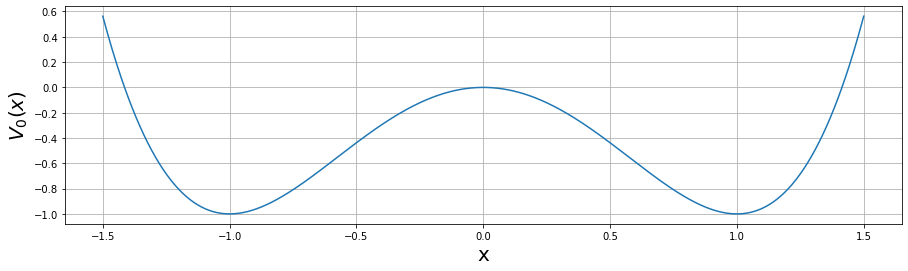

In [2]:
Vb = 1
l = 1

def V0(X):
    return 4*Vb*( -(X**2)/(2*l**2) + (X**4)/(4*l**4) )

t = 0

xx = np.linspace(-l*1.5, l*1.5, 1000)

plt.figure(figsize=(15,4))
plt.plot(xx, [V0(x) for x in xx])
plt.ylabel("$V_0(x)$", fontsize=20)
plt.xlabel("x", fontsize=20)
plt.grid()

Aggiungiamo una perturbazione periodica (armonica per semplicità):

$$ V(x) = V_0 + \epsilon \frac{V_b}{l} cos(\omega t)$$

Derivando otteniamo l'equazione per la dinamica di $x$:

$$\frac{dx}{dt} = 4\frac{Vb}{l} \left( \frac{x}{l} - \left( \frac{x}{l} \right)^3 \right)$$

A cui infine aggiungiamo un contributo stocastico:

$$ dx = 4\frac{Vb}{l} \left( \frac{x}{l} - \left( \frac{x}{l} \right)^3 \right)dt + \sqrt{2Ddw_t} $$

Dove $dw_t$ è un processo di Wiener e $\sqrt{2D}$ rappresenta la deviazione standard delle fluttuazioni.

Per valori troppo alti di $D$ il rumore domina sulla perturbazione e si perde la periodicità, mentre per valori troppo bassi di $D$ il rumore non è sufficiente a saltare da una buca all'altra. A metà tra questi due regimi esiste un valore di $D$ che massimizza la probabilità di cambiare buca ogni mezzo periodo.
Si può ricavare un espressione (approssimata) di tale valore dalla formula di Kramers per il tempo di salto $\tau$:

$$ \tau = \frac{2 \pi}{ |\sqrt{V_0''(\pm l)V_0''(0)|} } e^{\frac{V_b}{D}} =
          \frac{\pi}{ \sqrt{8} V_b } e^{\frac{V_b}{D}} =
          \frac{1}{\nu_s} e^{\frac{V_b}{D}}$$

Se imponiamo che il tempo di salto sia pari a mezzo periodo otteniamo:

$$ D = \frac{V_b}{\ln \left( \frac{ \pi \nu_s}{\omega} \right) } $$

In [3]:
tmax = 50000
dt   = 0.1

eps = 0.1

nu = np.sqrt(8)*Vb / (np.pi*l*l) # time unit = Vb/l
w = 2*np.pi / 10000

D_opt = Vb/np.log(np.pi*nu/w)

X0 = 0 # Initial value


def RHS_perturbed(X,t):
    return 4*(Vb/l)*( (X/l) - (X/l)**3 - eps*np.sin(w*t) )

def RHS_unperturbed(X,t):
    return 4*(Vb/l)*( (X/l) - (X/l)**3 )

def sigma(T,t):
    return np.sqrt( 2*D_opt)

tt = np.arange(0, tmax+dt, dt)

TT_noise        = sdeint.itoint(RHS_unperturbed, sigma, X0, tt) #dy = f(y,t)dt + G(y,t)dW
TT_perturbation = odeint(RHS_perturbed, X0, tt) #dy = f(y,t)dt + G(y,t)dW
TT_resonance    = sdeint.itoint(RHS_perturbed, sigma, X0, tt) #dy = f(y,t)dt + G(y,t)dW

Tmax = max(TT_resonance)
Tmin = min(TT_resonance)


Text(0.5, 1.0, 'Perturbation and stochastic noise (stochastic resonance)')

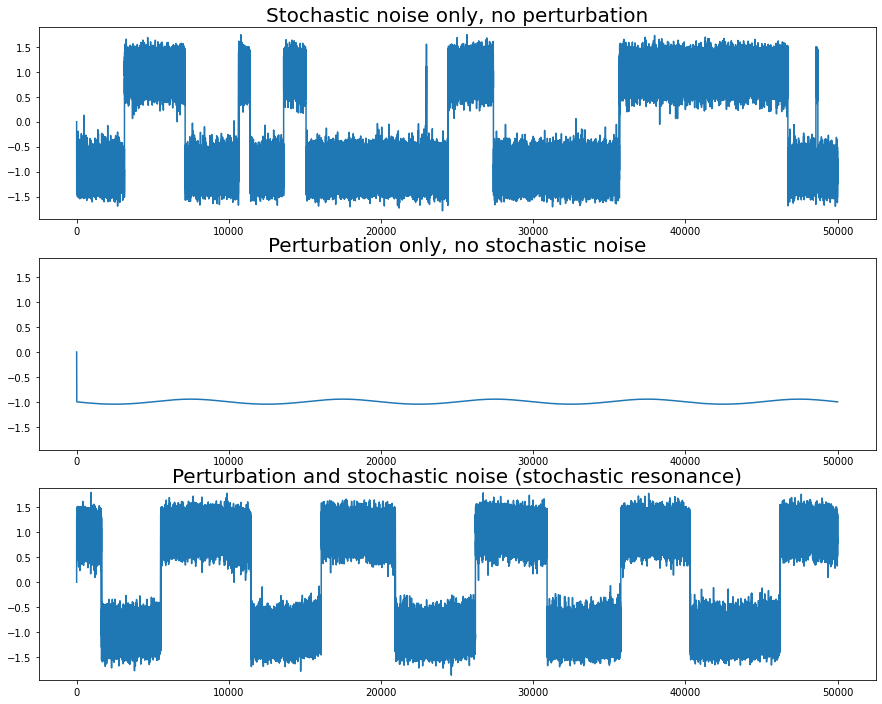

In [4]:
fig, ax = plt.subplots(3, 1, figsize=(15,12))

for axis in ax:
    axis.set_ylim(Tmin*1.05, Tmax*1.05)

ax[0].plot(tt, TT_noise)
ax[0].set_ylim(1.05*min(TT_resonance),1.05*max(TT_resonance))
ax[0].set_title('Stochastic noise only, no perturbation', fontsize=20)
ax[1].plot(tt, TT_perturbation)
ax[1].set_ylim(1.05*min(TT_resonance),1.05*max(TT_resonance))
ax[1].set_title('Perturbation only, no stochastic noise', fontsize=20)
ax[2].plot(tt, TT_resonance)
ax[2].set_ylim(1.05*min(TT_resonance),1.05*max(TT_resonance))
ax[2].set_title('Perturbation and stochastic noise (stochastic resonance)', fontsize=20)
